In [121]:
import re 
import pandas as pd
import numpy as np
from datetime import date, datetime, timedelta
from analytics_utils.bigquery_utils import get_bq_client, BigQuery
import matplotlib.pyplot as plt
from collections import Counter
from hs_fetch.fast_fetch.recipes.utils import get_relevant_fetch_recipes_names
from hs_fetch.utils.fetch_accounts_config_objects import get_fetch_config
from hs_gimme.constants.clients import ClientsNames
from datetime import datetime

In [122]:
STAGE_MAP = {
    'New': 1, 'Review': 2, 'Marked Relevant': 4, 
    'Opened': 2, 'Clicked': 2, 'Delivered': 4, 
    'Suppressed': 3, 'Dismissed': 3
}

REVERSE_STAGE_MAP = {
    1: 'New',
    2: 'Review',
    3: 'Dismissed',
    4: 'Marked Relevant'
}

DIM_MAP = {
    'Client': "fetch_recommendation_activity_customer", 
    'Client Industry': "Industry", 
    'Req Seniority': "dim_req_required_seniority_level", 
    'Req Top Category': "dim_req_top_category_calculated"
}

PATTERN_DELETE = r'(?=.+posit.+fill.+)|(?=.+posit.+interna.+)|(?=.+terna.+nly.+)|(?=.+interna.+fill.+)|(?=.+cand.+not.+interested.+)|(?=.+not.+reach.+)|(?=.+reach.+not.+)|(?=.+urrent.+employ.+)|(?=.*\bprocess\b.*\banother\b.*\breq\b)'

REASONS_TO_FILTER = {
    'other: Position will be filled internally ',
    'Candidate invited to apply',
    'In process in another req ',
    'Current Employee',
    'other: Position filled',
    'other: Internal only',
    'Qualified but candidate not interested at this time',
    
}

REASONS_TO_FILTER = {x.lower().strip() for x in REASONS_TO_FILTER}

def check_id(user_id):
    if user_id:
        if 'test' in user_id:
            return False
        elif str(user_id).endswith('-1'):
            return False
    return True

client_industry = pd.read_excel('planhat-companies-Oct-29-2023.xlsx')

In [163]:
def get_dataframe(from_date, to_date, account=None):
    db_client = get_bq_client('production')
    sql = f"""
        SELECT
            fetch_recommendation_activity.id as recommendation_id,
            creation_date_key,
            creation_ts,
            fetch_type,
            recommendation_status,
            fact_recommendation_status_history.analytics_fetch_status_bucket  AS fact_recommendation_status_history_fetch_bucket,
            fetch_recommendation_activity.req_id  AS fetch_recommendation_activity_req_id,
            fetch_recommendation_activity.talent_id  AS fetch_recommendation_activity_talent_id,
            fact_recommendation_status_history.reason  AS fact_recommendation_status_history_reason,
            (DATE(fact_recommendation_status_history.status_ts )) AS fact_recommendation_status_history_status_at_date,
            fetch_recommendation_activity.customer  AS fetch_recommendation_activity_customer,
            dim_req.required_seniority_level  AS dim_req_required_seniority_level,
            dim_req.top_category  AS dim_req_top_category_calculated,
            fact_recommendation_status_history.user_id  AS fact_recommendation_status_history_user_id
        FROM `hs-analytics.all_customers.dwh_hs_dim_recommendation`
             AS fetch_recommendation_activity
        LEFT JOIN `hs-analytics.all_customers.dwh_hs_fact_recommendation_status_history`
             AS fact_recommendation_status_history ON fetch_recommendation_activity.key = fact_recommendation_status_history.recommendation_key
            and fetch_recommendation_activity.customer = fact_recommendation_status_history.customer
        FULL OUTER JOIN `hs-analytics.all_customers.dwh_hs_dim_req`
             AS dim_req ON dim_req.key = fetch_recommendation_activity.req_key
            and dim_req.customer = fetch_recommendation_activity.customer
        WHERE (fact_recommendation_status_history.analytics_fetch_status_bucket ) IN ('Dismissed', 'Marked Relevant', 'Review') 
         --   AND fetch_recommendation_activity.customer = "{account}"
            AND ((( fact_recommendation_status_history.status_ts  ) >= (TIMESTAMP("{str(from_date)}")) 
            AND ( fact_recommendation_status_history.status_ts  ) < (TIMESTAMP("{str(to_date)}")))) 
            AND (fetch_recommendation_activity.customer not in ( 'princeton',
                 'arizona_wd_staging',
                 'antigua',
                 'havana',
                 'seoul_icims',
                 'arizona' ))
        GROUP BY
            1,
            2,
            3,
            4,
            5,
            6,
            7,
            8,
            9,
            10,
            11,
            12,
            13,
            14
    """
    job_result = db_client.execute(sql)
    df = job_result['query_reults'].to_dataframe()
    df.to_csv('cache_dump.csv', index=None)
    df['Date'] = pd.to_datetime(df['fact_recommendation_status_history_status_at_date'])
    return df

In [164]:
def prepare_df(df):
    calc_df = df.copy()

    calc_df['Date'] = pd.to_datetime(calc_df['fact_recommendation_status_history_status_at_date'])
    for period in ('M', 'W', '2W'):
        calc_df[f'Period {period}'] = calc_df['Date'].dt.to_period(period)

    calc_df['bucket_code'] = calc_df['fact_recommendation_status_history_fetch_bucket'].map(STAGE_MAP)
    calc_df['pair_id'] = calc_df['fetch_recommendation_activity_req_id'].fillna('nan') + '_' + calc_df['fetch_recommendation_activity_talent_id'].fillna('nan')

    leads_to_filter = set(calc_df[
        calc_df['fact_recommendation_status_history_reason'].fillna('').apply(
            lambda x: (bool(re.findall(PATTERN_DELETE, x.lower())) and ('qualif' not in x.lower())) or x.lower().strip() in REASONS_TO_FILTER
        )
    ]['pair_id'].values)


    calc_df[
        calc_df['fact_recommendation_status_history_reason'].fillna('').apply(
            lambda x: (bool(re.findall(PATTERN_DELETE, x.lower())) and ('qualif' not in x.lower())) or x.lower().strip() in REASONS_TO_FILTER
        )
    ]['bucket_code'] = STAGE_MAP['Marked Relevant']

    calc_df = calc_df[
        (~calc_df['pair_id'].isin(leads_to_filter)) & 
        (calc_df['fact_recommendation_status_history_user_id'].fillna('').apply(check_id))
    ]
    grouped_df = calc_df.groupby(
        ['pair_id'], as_index=False
    ).agg(
        {"bucket_code": "max",
         'fetch_recommendation_activity_req_id': 'first',
         'fetch_recommendation_activity_talent_id': 'first',
         'fetch_recommendation_activity_customer': 'first',
         'fact_recommendation_status_history_user_id': 'first',
         'Date': 'max',
         'Period M': 'max',
         'Period W': 'max',
         'Period 2W': 'max',     
         'dim_req_top_category_calculated': 'first',
         'dim_req_required_seniority_level': 'first',
        })

    grouped_df['Max Status Bucket'] = grouped_df['bucket_code'].map(REVERSE_STAGE_MAP)
    grouped_df = pd.concat([grouped_df, pd.get_dummies(grouped_df['Max Status Bucket'])], axis=1)
    grouped_df = grouped_df.dropna(subset=['Max Status Bucket'])

    client_industry['Account Name'] = client_industry['Account Name'].str.lower()
    grouped_df = pd.merge(grouped_df, client_industry, 
                          left_on='fetch_recommendation_activity_customer', 
                          right_on='Account Name', how='left')
    return grouped_df

In [165]:
def calc_rate(ddf):
    return ddf['Marked Relevant'].sum() / (ddf['Marked Relevant'] + ddf['Dismissed'] + ddf['Review']).sum()

In [166]:
raw_df = get_dataframe(date(2024, 2, 6), date(2024, 12, 28))
raw_df.shape

(10595, 15)

In [167]:
def get_recipe(row):
    return get_relevant_fetch_recipes_names(
            account_id=row['fetch_recommendation_activity_customer'],
            req_id=row['fetch_recommendation_activity_req_id'],
            interactive_input={},
            fetch_config=get_fetch_config(row['fetch_recommendation_activity_customer'], None),
            environment=None,
            es_tag=None,
    )

In [88]:
ACCOUNT = 'port'
ACCOUNTS = {
    ClientsNames.ANTALYA,
    ClientsNames.PORTO,
    ClientsNames.SEATTLE,
    ClientsNames.MOSCOW,
    ClientsNames.ATHENS,
    ClientsNames.CANCUN,
    ClientsNames.INDIANA,
    ClientsNames.ARIZONA,
    ClientsNames.OXFORD,
}
#prep_df = prepare_df(raw_df[raw_df['fetch_recommendation_activity_customer'].isin(ACCOUNTS)])
prep_df = prepare_df(raw_df[raw_df['fetch_recommendation_activity_customer'] == ACCOUNT])
prep_df['user_cat_pair'] = prep_df['fact_recommendation_status_history_user_id'] + prep_df['dim_req_top_category_calculated']
prep_df['recipe'] = prep_df.apply(get_recipe, axis=1)
prep_df.shape, prep_df['recipe'].value_counts()

/var/folders/_p/8_m91crj199_rd7sndkxncc80000gp/T/ipykernel_33038/3353077257.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  calc_df[


((1167, 20),
 base_fetch                                   781
 base_fetch&legacy_query_fetch_for_ab_test    386
 Name: recipe, dtype: int64)

In [89]:
a_df = prep_df[prep_df['recipe'] == 'base_fetch&legacy_query_fetch_for_ab_test']
b_df = prep_df[prep_df['recipe'] == 'base_fetch']
a_df.shape, b_df.shape

((386, 20), (781, 20))

In [90]:
calc_rate(a_df), calc_rate(b_df)

(0.4067357512953368, 0.6542893725992317)

In [91]:
relevant_pairs = set(a_df['user_cat_pair'].value_counts().loc[lambda x: x > 10].index) & set(b_df['user_cat_pair'].value_counts().loc[lambda x: x > 10].index)
len(relevant_pairs)

5

In [92]:
relevant_pairs

{'ADV111Medical',
 'ADV197Customer_Support',
 'ADV197Security',
 'ADV251Medical',
 'ADV262Medical'}

In [93]:
filtered_a_df = a_df[a_df['user_cat_pair'].isin(relevant_pairs)].copy()
filtered_a_df.shape

(149, 20)

In [94]:
filtered_b_df = b_df[b_df['user_cat_pair'].isin(relevant_pairs)].copy()
filtered_b_df.shape

(261, 20)

In [95]:
calc_rate(filtered_a_df), calc_rate(filtered_b_df)

(0.3422818791946309, 0.4942528735632184)

In [96]:
filtered_a_df['algo'] = 'OLD'
filtered_b_df['algo'] = 'NEW'
new_df = pd.concat([filtered_a_df, filtered_b_df])
new_df.shape

(410, 21)

In [105]:
gb = ['fact_recommendation_status_history_user_id', 'dim_req_top_category_calculated', 'algo']
gdf = new_df.groupby(gb).sum()[['Marked Relevant', 'Dismissed', 'Review']]

In [106]:
gdf = gdf[(gdf['Marked Relevant'] > 1) & (gdf['Dismissed'] > 1)]

In [107]:
gdf['total'] = gdf['Marked Relevant'] + gdf['Dismissed'] + gdf['Review']
gdf['rate'] = gdf['Marked Relevant'] / gdf['total']
gdf['num_of_reqs'] = new_df.groupby(gb)['fetch_recommendation_activity_req_id'].nunique()

In [108]:
gdf.reset_index().groupby('algo')[['rate']].mean()

,rate
algo,
NEW,0.391624
OLD,0.274017


In [109]:
udf = gdf.unstack().dropna()
udf['ratio'] = (udf[('rate', 'NEW')] / udf[('rate', 'OLD')])

In [110]:
udf

Marked Relevant  \
algo                                                                                   NEW   
fact_recommendation_status_history_user_id dim_req_top_category_calculated                   
ADV111                                     Medical                                     6.0   
ADV197                                     Security                                   99.0   
ADV251                                     Medical                                     9.0   
ADV262                                     Medical                                     3.0   

                                                                                  \
algo                                                                         OLD   
fact_recommendation_status_history_user_id dim_req_top_category_calculated         
ADV111                                     Medical                           2.0   
ADV197                                     Security                         24.0   
ADV251                                     Medical                           8.0   
ADV262                                     Medical                           2.0   

                                                                           Dismissed  \
algo                                                                             NEW   
fact_recommendation_status_history_user_id dim_req_top_category_calculated             
ADV111                                     Medical                              34.0   
ADV197                                     Security                             22.0   
ADV251                                     Medical                              18.0   
ADV262                                     Medical                              50.0   

                                                                                  \
algo                                                                         OLD   
fact_recommendation_status_history_user_id dim_req_top_category_calculated         
ADV111                                     Medical                          14.0   
ADV197                                     Security                         16.0   
ADV251                                     Medical                          16.0   
ADV262                                     Medical                          51.0   

                                                                           Review  \
algo                                                                          NEW   
fact_recommendation_status_history_user_id dim_req_top_category_calculated          
ADV111                                     Medical                            0.0   
ADV197                                     Security                           0.0   
ADV251                                     Medical                            0.0   
ADV262                                     Medical                            0.0   

                                                                                 \
algo                                                                        OLD   
fact_recommendation_status_history_user_id dim_req_top_category_calculated        
ADV111                                     Medical                          0.0   
ADV197                                     Security                         0.0   
ADV251                                     Medical                          0.0   
ADV262                                     Medical                          0.0   

                                                                            total  \
algo                                                                          NEW   
fact_recommendation_status_history_user_id dim_req_top_category_calculated          
ADV111                                     Medical                           40.0   
ADV197                                     Security                         121.0   
ADV251            

In [192]:
rdf = raw_df[raw_df['fetch_recommendation_activity_customer'] == 'porto']

In [193]:
rdf.shape

(1528, 15)

In [194]:
rdf = rdf[(rdf['recommendation_status'] != 'new') & (rdf['fetch_type'] == 'passive_fetch')]
rdf.shape

(86, 15)

In [195]:
rdf['recommendation_status'].value_counts(dropna=False)

viewed       38
dismissed    33
contacted    15
Name: recommendation_status, dtype: int64

In [196]:
rdf['recommendation_status'].value_counts(dropna=False)

viewed       38
dismissed    33
contacted    15
Name: recommendation_status, dtype: int64

In [198]:
len(set(rdf['recommendation_id']))

76

In [201]:
rdf['creation_ts'].describe()

/var/folders/_p/8_m91crj199_rd7sndkxncc80000gp/T/ipykernel_33038/2161962815.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  rdf['creation_ts'].describe()


count                                   86
unique                                  76
top       2024-02-06 17:30:11.737000+00:00
freq                                     2
first     2023-12-19 21:06:37.845000+00:00
last      2024-02-07 13:58:44.360000+00:00
Name: creation_ts, dtype: object

In [207]:
ddf = rdf[pd.to_datetime(rdf['creation_ts']).dt.date >= date(2024, 2, 6)]

In [208]:
ddf.shape

(75, 15)

<Axes: >

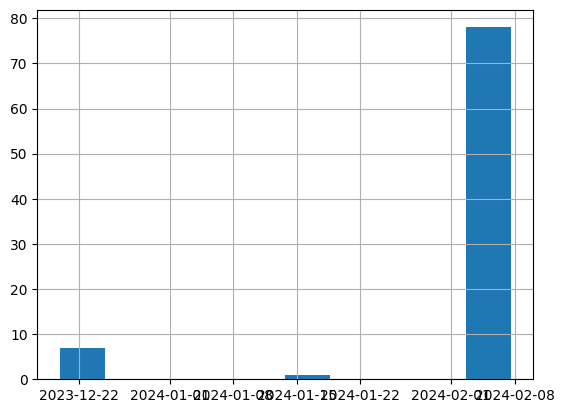

In [209]:
rdf['creation_ts'].hist()

In [211]:
list(set(ddf['recommendation_id']))

['PHC2400193_PHC616901',
 'PHC2400522_PHC683103',
 'PHC2400245_PHC557011',
 'PHC2400320_PHC663594',
 'PHC2400320_PHC490736',
 'PHC2310589_PHC347679',
 'PHC2401596_PHC666243',
 'PHC2401399_PHC724336',
 'PHC2400320_PHC608229',
 'PHC2400320_PHC635292',
 'PHC2400320_PHC546066',
 'PHC2400291_PHC230652',
 'PHC2401399_PHC503739',
 'PHC2400193_PHC634623',
 'PHC2400245_PHC541715',
 'PHC2312372_PHC330340',
 'PHC2400953_PHC187891',
 'PHC2401189_PHC724336',
 'PHC2400522_PHC481791',
 'PHC2400953_PHC583700',
 'PHC2401596_PHC640058',
 'PHC2401596_PHC536613',
 'PHC2401399_PHC80840',
 'PHC2400522_PHC505563',
 'PHC2400291_PHC497018',
 'PHC2400245_PHC468959',
 'PHC2400193_PHC503078',
 'PHC2401515_PHC615258',
 'PHC2401596_PHC640241',
 'PHC2400320_PHC513369',
 'PHC2400522_PHC636114',
 'PHC2400245_PHC626700',
 'PHC2400953_PHC460563',
 'PHC2401596_PHC628190',
 'PHC2401596_PHC665198',
 'PHC2400193_PHC496415',
 'PHC2400522_PHC530573',
 'PHC2400953_PHC533723',
 'PHC2400291_PHC500319',
 'PHC2400953_PHC487870',
 

In [216]:
    db_client = get_bq_client('production')
    sql = f"""
        SELECT
            *
        FROM `hs-analytics.all_customers.dwh_hs_dim_recommendation` LIMIT 10
        """
    job_result = db_client.execute(sql)
    sdf = job_result['query_reults'].to_dataframe()

In [217]:
sorted(sdf.columns)

['address_line',
 'ats_application_id',
 'ats_source',
 'candidate_id',
 'creation_date_key',
 'creation_ts',
 'crm_candidate_id',
 'crm_source',
 'customer',
 'data_sources',
 'dismissed_date',
 'email',
 'employee_key',
 'external_pool_id',
 'external_talent_id',
 'fetch_candidate_key',
 'fetch_type',
 'fetched_from_pipeline',
 'grade',
 'id',
 'is_contingent',
 'key',
 'likelihood_to_apply',
 'municipality',
 'name',
 'notification_id',
 'population_types',
 'recommendation_status',
 'removed_date_key',
 'removed_ts',
 'req_id',
 'req_key',
 'score',
 'security_clearance',
 'selected_date_key',
 'selected_ts',
 'source_system',
 'sub_pool_id',
 'talent_id',
 'updated_at']

In [218]:
sdf['selected_ts'].describe()

/var/folders/_p/8_m91crj199_rd7sndkxncc80000gp/T/ipykernel_33038/2020807685.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  sdf['selected_ts'].describe()


count                                   10
unique                                   3
top       2022-04-16 21:11:16.133000+00:00
freq                                     4
first     2022-04-16 21:11:13.388000+00:00
last      2022-04-16 21:11:28.096000+00:00
Name: selected_ts, dtype: object